In [1]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# Imports

import os
import sys
import time
import json
import copy
import cortex
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


sys.path.append("{}/../../analysis_code/utils".format(os.getcwd()))
from plot_utils import *
from pycortex_utils import draw_cortex, set_pycortex_config_file, load_surface_pycortex, create_colormap, get_rois
from surface_utils import load_surface
from maths_utils import weighted_regression


In [2]:
# Import data base
main_dir = '/Users/uriel/disks/meso_shared'
# main_dir = '/home/ulascombes/disks/meso_shared'

project_dir = 'RetinoMaps'
suffix = 'Sac_Pur'

with open('../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
rois = analysis_info['rois']
subjects = analysis_info['subjects']
TR = analysis_info['TR']
rois = analysis_info['rois']
ecc_threshold = analysis_info['ecc_th']
size_threshold = analysis_info['size_th']
rsqr_threshold = analysis_info['rsqr_th']
amplitude_threshold = analysis_info['amplitude_th']
stats_threshold = analysis_info['stats_th']
n_threshold = analysis_info['n_th']
prf_task_name = analysis_info['prf_task_name']
screen_size_cm = analysis_info['screen_size_cm']


fig_width = 1440

In [3]:
# Plot settings
colormap_dict = {'V1': (243, 231, 155),
                 'V2': (250, 196, 132),
                 'V3': (248, 160, 126),
                 'V3AB': (235, 127, 134),
                 'LO': (150, 0, 90), 
                 'VO': (0, 0, 200),
                 'hMT+': (0, 25, 255),
                 'iIPS': (0, 152, 255),
                 'sIPS': (44, 255, 150),
                 'iPCS': (151, 255, 0),
                 'sPCS': (255, 234, 0),
                 'mPCS': (255, 111, 0)
                }
roi_colors = ['({},{},{})'.format(*rgb) for rgb in colormap_dict.values()]


roi_colors_dict = {'V1': 'rgb(243, 231, 155)', 
                   'V2': 'rgb(250, 196, 132)', 
                   'V3': 'rgb(248, 160, 126)', 
                   'V3AB': 'rgb(235, 127, 134)', 
                   'LO': 'rgb(150, 0, 90)',  
                   'VO': 'rgb(0, 0, 200)', 
                   'hMT+': 'rgb(0, 25, 255)', 
                   'iIPS': 'rgb(0, 152, 255)', 
                   'sIPS': 'rgb(44, 255, 150)', 
                   'iPCS': 'rgb(151, 255, 0)', 
                   'sPCS': 'rgb(255, 234, 0)', 
                   'mPCS': 'rgb(255, 111, 0)'}


In [4]:
# Template settings
template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                      axes_width=2,
                      axes_font_size=15,
                      bg_col="rgba(255, 255, 255, 1)",
                      font='Arial',
                      title_font_size=15,
                      plot_width=1.5)
fig_template = plotly_template(template_specs)

# Participants 

In [28]:
participants_fn = '{}/{}/participants.tsv'.format(main_dir, project_dir)

In [29]:
participants = pd.read_table(participants_fn)

In [34]:
age_mean = participants['age'].mean()
age_min = participants['age'].min()
age_max = participants['age'].max()
n_female = participants.loc[participants['sex']=='F', 'sex'].count()
print('their is {} female participant mean age is {} age range is {}-{}'.format(n_female, age_mean, age_min, age_max))

their is 10 female participant mean age is 29.2 age range is 19-54


# pRF settings 

In [26]:
prf_events_fn = '{}/{}/sub-02/ses-01/func/sub-02_ses-01_task-pRF_run-01_events.tsv'.format(main_dir, project_dir)

In [27]:
prf_events = pd.read_table(prf_events_fn)

In [24]:
blanke_time = prf_events.loc[(prf_events['bar_direction'] == 9) & (prf_events['bar_period'] == 1), 'duration'].sum()
blanke_TR = prf_events.loc[(prf_events['bar_direction'] == 9) & (prf_events['bar_period'] == 1), 'duration'].count()


In [25]:
print('without stimulus time is {} ({} TRs)'.format(blanke_time.round(2), blanke_TR))

without stimulus time is 19.21 (16 TRs)


In [ ]:
# Compute bar step in DVA 



# Behaviour results

## Make DF

In [49]:
n_runs_prf = 5

df_prf_beh = pd.DataFrame()
for n_subject, subject in enumerate(subjects):
    if subject == 'sub-01': session = 'ses-02'
    else: session = 'ses-01'
    for n_run in range(n_runs_prf):
        prf_events_fn = '{}/{}/{}/{}/func/{}_{}_task-pRF_run-0{}_events.tsv'.format(main_dir, project_dir, subject, session, subject, session ,n_run+1)
        prf_events_raw = pd.read_table(prf_events_fn)
        
        # Find TRs with bar stimulation
        prf_events = prf_events_raw.loc[prf_events_raw['bar_direction'] != 9].copy()
            
        # concat runs
        if n_run==0: 
            perf_runs_indiv_concat = prf_events.response_val.values
            stair_runs_indiv_concat = prf_events.stim_stair_val.values
        else: 
            perf_runs_indiv_concat = np.concatenate([perf_runs_indiv_concat, prf_events.response_val.values])
            stair_runs_indiv_concat = np.concatenate([stair_runs_indiv_concat, prf_events.stim_stair_val.values])
            
    # Compute cumulative mean of median and staircase
    perf_runs_indiv = np.zeros(stair_runs_indiv_concat.shape[0])
    stair_runs_indiv = np.zeros(stair_runs_indiv_concat.shape[0])
    for t in range(stair_runs_indiv_concat.shape[0]):
                    perf_runs_indiv[t] = np.nanmean(perf_runs_indiv_concat[0:t])
                    stair_runs_indiv[t] = np.nanmean(stair_runs_indiv_concat[0:t])
                
    # Make DF for barplot
    # perf
    perf_median_indiv = np.nanmedian(perf_runs_indiv)
    perf_ci_low_indiv = np.nanquantile(perf_runs_indiv, 0.025)
    perf_ci_up_indiv = np.nanquantile(perf_runs_indiv, 0.975)

    prf_beh_df_indiv = pd.DataFrame()
    prf_beh_df_indiv['subject'] = [subject]
    prf_beh_df_indiv['perf_median'] = [perf_median_indiv]
    prf_beh_df_indiv['perf_ci_low'] = [perf_ci_low_indiv]
    prf_beh_df_indiv['perf_ci_up'] = [perf_ci_up_indiv]

    # staircase
    stair_median_indiv = np.nanmedian(stair_runs_indiv)
    stair_ci_low_indiv = np.nanquantile(stair_runs_indiv, 0.025)
    stair_ci_up_indiv = np.nanquantile(stair_runs_indiv, 0.975)

    prf_beh_df_indiv['stair_median'] = [stair_median_indiv]
    prf_beh_df_indiv['stair_ci_low'] = [stair_ci_low_indiv]
    prf_beh_df_indiv['stair_ci_up'] = [stair_ci_up_indiv] 
    
    
    # Concat subjects
 
    prf_beh_trials_df_indiv = pd.DataFrame({
        'subject':[subject]*perf_runs_indiv.shape[0], 
        'perf': perf_runs_indiv, 
        'stair': stair_runs_indiv})
    
    if n_subject == 0: prf_beh_trials_df = prf_beh_trials_df_indiv.copy()
    else: prf_beh_trials_df = pd.concat([prf_beh_trials_df, prf_beh_trials_df_indiv])#.reset_index(drop=True, inplace=True)

    
    
    
    
    
    
#     if n_subject == 0: 
#         perf_runs = perf_runs_indiv
#         stair_runs = stair_runs_indiv
#         prf_beh_df_concat = prf_beh_df_indiv.copy()
#     else: 
#         perf_runs = np.vstack([perf_runs, perf_runs_indiv])
#         stair_runs = np.vstack([stair_runs, stair_runs_indiv])
#         prf_beh_df_concat = pd.concat([prf_beh_df_concat, prf_beh_df_indiv])
        

# # compute inter subject median and CI
# # Defind sub-07 (position 6) and sub-12 (position 10) as outlier 

# correct_subject = [i for i in range(perf_runs.shape[0]) if i not in [6, 10]]
# filtered_perf_runs = perf_runs[correct_subject, :]
# filtered_stair_runs = stair_runs[correct_subject, :]

# perf_runs_median = np.nanmedian(filtered_perf_runs, axis=0)
# stair_runs_median = np.nanmedian(filtered_stair_runs, axis=0)

# perf_runs_ci_low = np.nanquantile(filtered_perf_runs, 0.025, axis=0)
# perf_runs_ci_up = np.nanquantile(perf_runs, 0.975, axis=0)

# stair_runs_ci_low = np.nanquantile(filtered_stair_runs, 0.025, axis=0)
# stair_runs_ci_up = np.nanquantile(filtered_stair_runs, 0.975, axis=0)

# # prf_beh_df = pd.DataFrame([prf_beh_df_concat.median()], columns=prf_beh_df_concat.columns)
# prf_beh_df = prf_beh_df_concat[~prf_beh_df_concat['subject'].isin(['sub-07', 'sub-12'])].drop(columns=['subject']).median().to_frame().T

In [53]:
prf_beh_df = prf_beh_df_concat[~prf_beh_df_concat['subject'].isin(['sub-07', 'sub-12'])].drop(columns=['subject']).median().to_frame().T
prf_beh_df = pd.concat()

In [82]:
prf_beh_df_concat.columns

Index(['subject', 'perf_median', 'perf_ci_low', 'perf_ci_up', 'stair_median',
       'stair_ci_low', 'stair_ci_up'],
      dtype='object')

In [99]:
import pandas as pd

# Supposons que prf_beh_df_concat est déjà défini et subject_excluded est une liste de sujets à exclure
# subject_excluded = ['subject1', 'subject2', ...]

# Filtrer les sujets exclus
filtered_df = prf_beh_df_concat[~prf_beh_df_concat['subject'].isin(subject_excluded)]
excluded_df = prf_beh_df_concat[prf_beh_df_concat['subject'].isin(['sub-07', 'sub-12'])]

# Calculer la médiane pour chaque colonne numérique, en excluant la colonne 'subject'
median_values = filtered_df.drop(columns=['subject']).median()

# Créer un nouveau DataFrame avec la médiane et la colonne 'subject' définie sur 'group'
prf_beh_df_median_subject = pd.DataFrame(median_values).T
prf_beh_df_median_subject['subject'] = 'group'
prf_beh_df_median_subject = pd.concat([prf_beh_df_median_subject, excluded_df])



In [100]:
prf_beh_df_median_subject

,perf_median,perf_ci_low,perf_ci_up,stair_median,stair_ci_low,stair_ci_up,subject
0,0.799666,0.785826,0.889148,6.481121,5.901047,8.504062,group
0,0.583078,0.457457,0.857630,10.636364,8.039583,12.023978,sub-07
0,0.570497,0.183890,1.000000,7.588068,5.665998,12.335972,sub-12


In [59]:
# Réorganisation des données pour obtenir une colonne par sujet
perf_pivot = prf_beh_trials_df.pivot(columns='subject', values='perf')
stair_pivot = prf_beh_trials_df.pivot(columns='subject', values='stair')

# Calcul de la médiane entre les sujets, point par point
median_perf = perf_pivot.median(axis=1)
median_stair = stair_pivot.median(axis=1)

# Résultats
median_df = pd.DataFrame({'median_perf': median_perf, 'median_stair': median_stair})


In [76]:
subject_excluded = ['sub-07', 'sub-12']

# Filtrer le DataFrame pour exclure les sujets
filtered_df = prf_beh_trials_df[~prf_beh_trials_df['subject'].isin(subject_excluded)]

# Réorganisation des données pour obtenir une colonne par sujet
perf_pivot = filtered_df.pivot(columns='subject', values='perf')
stair_pivot = filtered_df.pivot(columns='subject', values='stair')

# Calcul de la médiane entre les sujets, point par point
median_perf = perf_pivot.median(axis=1)
quantile_2_5_perf = perf_pivot.quantile(0.025, axis=1)
quantile_97_5_perf = perf_pivot.quantile(0.975, axis=1)

median_stair = stair_pivot.median(axis=1)
quantile_2_5_stair = stair_pivot.quantile(0.025, axis=1)
quantile_97_5_stair = stair_pivot.quantile(0.975, axis=1)

# Créer le DataFrame avec les médianes et quantiles
median_df = pd.DataFrame({
    'subject': ['group'] * len(median_perf),
    'median_perf': median_perf,
    'quantile_2_5_perf': quantile_2_5_perf,
    'quantile_97_5_perf': quantile_97_5_perf,
    'median_stair': median_stair,
    'quantile_2_5_stair': quantile_2_5_stair,
    'quantile_97_5_stair': quantile_97_5_stair,
})

# Ajouter les sujets exclus et leurs valeurs
excluded_df = prf_beh_trials_df[prf_beh_trials_df['subject'].isin(subject_excluded)]
excluded_df = excluded_df.rename(columns={'perf': 'median_perf', 'stair': 'median_stair'})
# excluded_df['quantile_2_5_perf'] = excluded_df['median_perf']  # Valeurs à mettre à jour selon le besoin
# excluded_df['quantile_97_5_perf'] = excluded_df['median_perf']  # Valeurs à mettre à jour selon le besoin
# excluded_df['quantile_2_5_stair'] = excluded_df['median_stair']  # Valeurs à mettre à jour selon le besoin
# excluded_df['quantile_97_5_stair'] = excluded_df['median_stair']  # Valeurs à mettre à jour selon le besoin
# excluded_df['subject'] = excluded_df['subject']  # Garder le nom du sujet

# # Combiner les DataFrames
median_df = pd.concat([median_df, excluded_df], 
                       ignore_index=True)

In [78]:
median_df

,subject,median_perf,quantile_2_5_perf,quantile_97_5_perf,median_stair,quantile_2_5_stair,quantile_97_5_stair
0,group,NaN,NaN,NaN,NaN,NaN,NaN
1,group,1.000000,1.0,1.0,9.000000,9.00,9.000000
2,group,1.000000,0.0,1.0,9.000000,9.00,9.000000
3,group,1.000000,0.0,1.0,9.000000,9.00,9.333333
4,group,1.000000,0.0,1.0,9.000000,8.75,9.750000
...,...,...,...,...,...,...,...
1915,sub-12,0.647727,NaN,NaN,5.626772,NaN,NaN
1916,sub-12,0.647727,NaN,NaN,5.624214,NaN,NaN
1917,sub-12,0.648725,NaN,NaN,5.621664,NaN,NaN
1918,sub-12,0.648725,NaN,NaN,5.617555,NaN,NaN


## Plot 

### Subjects

In [19]:
# colors = [
#     "#1f77b4",  # bleu
#     "#ff7f0e",  # orange
#     "#2ca02c",  # vert
#     "#d62728",  # rouge
#     "#9467bd",  # violet
#     "#8c564b",  # marron
#     "#e377c2",  # rose
#     "#7f7f7f",  # gris
#     "#bcbd22",  # vert olive
#     "#17becf",  # cyan
#     "#aec7e8",  # bleu clair
#     "#ffbb78",  # orange clair
#     "#98df8a",  # vert clair
#     "#ff9896",  # rouge clair
#     "#c5b0d5",  # violet clair
#     "#c49c94",  # marron clair
#     "#f7b6d2",  # rose clair
#     "#c7c7c7",  # gris clair
#     "#dbdb8d",  # jaune olive
#     "#9edae5"   # cyan clair
# ]
colors = px.colors.qualitative.Alphabet

In [21]:
colors

['#AA0DFE',
 '#3283FE',
 '#85660D',
 '#782AB6',
 '#565656',
 '#1C8356',
 '#16FF32',
 '#F7E1A0',
 '#E2E2E2',
 '#1CBE4F',
 '#C4451C',
 '#DEA0FD',
 '#FE00FA',
 '#325A9B',
 '#FEAF16',
 '#F8A19F',
 '#90AD1C',
 '#F6222E',
 '#1CFFCE',
 '#2ED9FF',
 '#B10DA1',
 '#C075A6',
 '#FC1CBF',
 '#B00068',
 '#FBE426',
 '#FA0087']

In [25]:
colormap_subject_dict = {
    'sub-01': '#AA0DFE',
    'sub-02': '#3283FE',
    'sub-03': '#85660D',
    'sub-04': '#782AB6',
    'sub-05': '#565656',
    'sub-06': '#1C8356',
    'sub-07': '#16FF32',
    'sub-08': '#F7E1A0',
    'sub-09': '#E2E2E2',
    'sub-11': '#1CBE4F',
    'sub-12': '#C4451C',
    'sub-13': '#DEA0FD',
    'sub-14': '#FBE426',
    'sub-15': '#325A9B',
    'sub-16': '#FEAF16',
    'sub-17': '#F8A19F',
    'sub-18': '#90AD1C',
    'sub-20': '#F6222E',
    'sub-21': '#1CFFCE',
    'sub-22': '#2ED9FF',
    'sub-23': '#B10DA1',
    'sub-24': '#C075A6',
    'sub-25': '#FC1CBF'
}


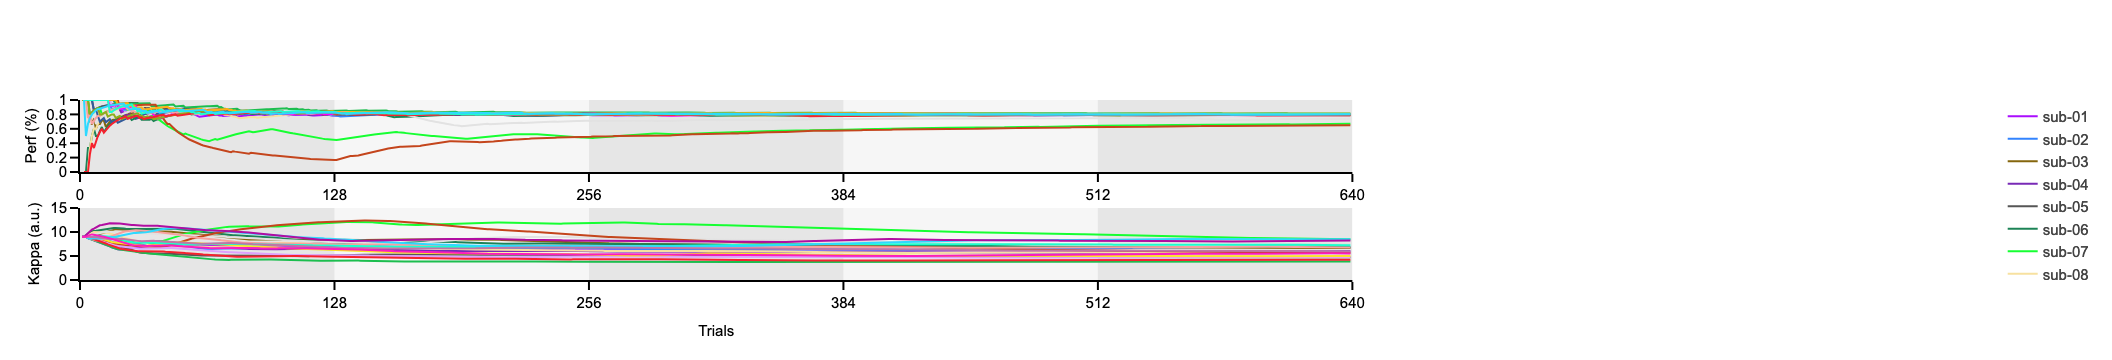

In [26]:
# Defind sublot 
fig = make_subplots(rows=2, cols=2, column_widths=[0.75, 0.25], vertical_spacing=0.20, print_grid=False)
# fig = make_subplots(rows=2, cols=1, vertical_spacing=0.20, print_grid=False)

perf_runs_median_clean = perf_runs_median[~np.isnan(perf_runs_median)]
perf_runs_ci_up_clean = perf_runs_ci_up[~np.isnan(perf_runs_ci_up)]
perf_runs_ci_low_clean = perf_runs_ci_low[~np.isnan(perf_runs_ci_low)]

for n_subject, subject in enumerate(subjects):
# for n_subject, subject in enumerate(['sub-07', 'sub-12']):
    # Perf 
    # plot perf across trials 
    fig.add_trace(go.Scatter(y=perf_runs[n_subject, :], 
                             line=dict(color=colors[n_subject]), 
                             name=subject, 
                             showlegend=False), 
                  row=1, col=1)

    # Staircase 
    # plot perf across trials 
    fig.add_trace(go.Scatter(y=stair_runs[n_subject, :], 
                             line=dict(color=colormap_subject_dict[subject]), 
                             name=subject), 
                  row=2, col=1)





step = 128
x_max = 640
for i in range(0, x_max, step):
    fig.add_shape(type="rect", 
                  x0=i, 
                  x1=i + step, 
                  y0=0, 
                  y1=15, 
                  fillcolor="gray" if (i // step) % 2 == 0 else "lightgray", 
                  opacity=0.2,
                  layer="below", 
                  line_width=0,
                  row="all",
                  col=1) 
# perf 
fig.update_xaxes(showline=True, range=[0,x_max], tickvals=[0, 128, 256, 384, 512, 640], ticktext=["0", "128", "256", "384", "512", "640"], row=1, col=1)
fig.update_yaxes(showline=True, range=[0,1], nticks=6, title='Perf (%)',row=1, col=1)

# fig.update_xaxes(showline=False, ticks='', showticklabels=False, title='Median performances', row=1, col=2)
# fig.update_yaxes(showline=True,range=[0,1], nticks=6, row=1, col=2)

# stair 
fig.update_xaxes(showline=True, range=[0,x_max], tickvals=[0, 128, 256, 384, 512, 640], ticktext=["0", "128", "256", "384", "512", "640"], title='Trials', row=2, col=1)
fig.update_yaxes(showline=True, range=[0,15], title='Kappa (a.u.)', row=2, col=1)

# fig.update_xaxes(showline=False, ticks='', showticklabels=False, title='Median kappa', row=2, col=2)
# fig.update_yaxes(showline=True,range=[0,15], row=2, col=2)


fig.update_layout(template=fig_template, showlegend=True)
fig.show()
fig.write_image("/Users/uriel/Downloads/prf_perf_all_sub.pdf")

### final

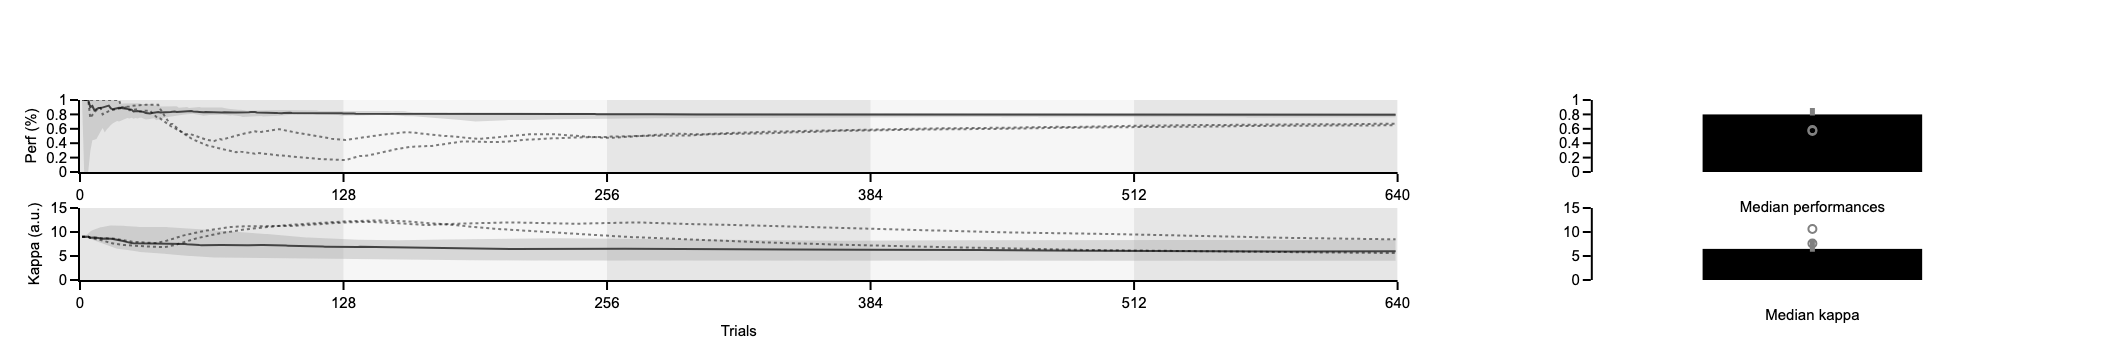

In [98]:
# Defind sublot 
fig = make_subplots(rows=2, cols=2, column_widths=[0.75, 0.25], vertical_spacing=0.20, print_grid=False)

# perf_runs_median_clean = perf_runs_median[~np.isnan(perf_runs_median)]
# perf_runs_ci_up_clean = perf_runs_ci_up[~np.isnan(perf_runs_ci_up)]
# perf_runs_ci_low_clean = perf_runs_ci_low[~np.isnan(perf_runs_ci_low)]

# stair_runs_median_clean = stair_runs_median[~np.isnan(stair_runs_median)]
# stair_runs_ci_up_clean = stair_runs_ci_up[~np.isnan(stair_runs_ci_up)]
# stair_runs_ci_low_clean = stair_runs_ci_low[~np.isnan(stair_runs_ci_low)]

##### Perf #####
# plot perf across trials 
fig.add_trace(go.Scatter(y=perf_runs_median, 
                         line=dict(color='black')), 
              row=1, col=1)

# Error area
fig.add_trace(go.Scatter(y=np.concatenate([perf_runs_ci_up, perf_runs_ci_low[::-1]]), 
                         x=np.concatenate([np.arange(len(perf_runs_ci_up)), np.arange(len(perf_runs_ci_low))[::-1]]), 
                         mode='lines', 
                         fill='toself', 
                         fillcolor='rgba(169, 169, 169, 0.4)', 
                         line=dict(width=0), 
                         showlegend=False), 
              row=1, col=1)

# make the bar plot 
fig.add_trace(go.Bar(y=prf_beh_df.perf_median, 
                     marker=dict(color='black'),
                     error_y=dict(type='data', 
                                  symmetric=False, 
                                  array=prf_beh_df.perf_ci_up - prf_beh_df.perf_median, 
                                  arrayminus=prf_beh_df.perf_median - prf_beh_df.perf_ci_low, 
                                  thickness=5, 
                                  width=0,
                                  color='gray'), 
                     width=0.5),
              
              row=1, col=2)

##### Staircase #####
# plot perf across trials 
fig.add_trace(go.Scatter(y=stair_runs_median, 
                         line=dict(color='black')), 
              row=2, col=1)

# Error area
fig.add_trace(go.Scatter(y=np.concatenate([stair_runs_ci_up, stair_runs_ci_low[::-1]]), 
                         x=np.concatenate([np.arange(len(stair_runs_ci_up)), np.arange(len(stair_runs_ci_low))[::-1]]), 
                         mode='lines', 
                         fill='toself', 
                         fillcolor='rgba(169, 169, 169, 0.4)', 
                         line=dict(width=0), 
                         showlegend=False), 
              row=2, col=1)

# make the bar plot 
fig.add_trace(go.Bar(y=prf_beh_df.stair_median, 
                     marker=dict(color='black'),
                     error_y=dict(type='data', 
                                  symmetric=False, 
                                  array=prf_beh_df.stair_ci_up - prf_beh_df.stair_median, 
                                  arrayminus=prf_beh_df.stair_median - prf_beh_df.stair_ci_low, 
                                  thickness=5, 
                                  width=0,
                                  color='gray'), 
                     width=0.5),
              
              row=2, col=2)

# Filtrer les données pour les sujets spécifiques
filtered_perf_data = prf_beh_df_concat[prf_beh_df_concat['subject'].isin(['sub-07', 'sub-12'])]

# Ajouter des points au bar plot pour 'Perf' uniquement pour les sujets 'sub-07' et 'sub-12'
fig.add_trace(go.Scatter(x=[0, 0],
                         y=filtered_perf_data.perf_median, 
                         mode='markers', 
                         marker=dict(color='rgba(255, 255, 255, 0)',  # Couleur de remplissage transparent
                                     line=dict(color='gray', width=2),  # Couleur et épaisseur du contour
                                     size=8),  
                         showlegend=False),
              row=1, col=2)

# Ajouter des points au bar plot pour 'Stair' uniquement pour les sujets 'sub-07' et 'sub-12'
fig.add_trace(go.Scatter(x=[0, 0],
                         y=filtered_perf_data.stair_median, 
                         mode='markers', 
                         marker=dict(color='rgba(255, 255, 255, 0)',  # Couleur de remplissage transparent
                                     line=dict(color='gray', width=2),  # Couleur et épaisseur du contour
                                     size=8),  
                         showlegend=False),
              row=2, col=2)

for outlier_idx in [6, 10]:
    # Perf - ajouter une ligne pointillée et opacité
    fig.add_trace(go.Scatter(y=perf_runs[outlier_idx,:], 
                             line=dict(color='black', dash='dot'), 
                             opacity=0.5),  # Réduit l'opacité
                  row=1, col=1)
    
    # Stair - ajouter une ligne pointillée et opacité
    fig.add_trace(go.Scatter(y=stair_runs[outlier_idx,:], 
                             line=dict(color='black', dash='dot'), 
                             opacity=0.5),  # Réduit l'opacité
                  row=2, col=1)


step = 128
x_max = 640
for i in range(0, x_max, step):
    fig.add_shape(type="rect", 
                  x0=i, 
                  x1=i + step, 
                  y0=0, 
                  y1=15, 
                  fillcolor="gray" if (i // step) % 2 == 0 else "lightgray", 
                  opacity=0.2,
                  layer="below", 
                  line_width=0,
                  row="all",
                  col=1) 
# perf 
fig.update_xaxes(showline=True, range=[0,x_max], tickvals=[0, 128, 256, 384, 512, 640], ticktext=["0", "128", "256", "384", "512", "640"], row=1, col=1)
fig.update_yaxes(showline=True, range=[0,1], nticks=6, title='Perf (%)',row=1, col=1)

fig.update_xaxes(showline=False, ticks='', showticklabels=False, title='Median performances', row=1, col=2)
fig.update_yaxes(showline=True,range=[0,1], nticks=6, row=1, col=2)

# stair 
fig.update_xaxes(showline=True, range=[0,x_max], tickvals=[0, 128, 256, 384, 512, 640], ticktext=["0", "128", "256", "384", "512", "640"], title='Trials', row=2, col=1)
fig.update_yaxes(showline=True, range=[0,15], title='Kappa (a.u.)', row=2, col=1)

fig.update_xaxes(showline=False, ticks='', showticklabels=False, title='Median kappa', row=2, col=2)
fig.update_yaxes(showline=True,range=[0,15], row=2, col=2)


fig.update_layout(template=fig_template, showlegend=False)
fig.show()
fig.write_image("/Users/uriel/Downloads/prf_perf.pdf")

In [96]:
filtered_perf_data.perf_median

0    0.583078
0    0.570497
Name: perf_median, dtype: float64

In [26]:
 perf_runs_median[~np.isnan(perf_runs_median)].shape[0] 

1023

In [30]:
perf_runs_median.shape

(1040,)

In [29]:
perf_runs_median[~np.isnan(perf_runs_median)].shape

(1023,)

In [17]:
a = np.nanmedian(stair_runs, axis=0)

In [41]:
perf_runs.shape

(20, 1040)

In [60]:
df_prf_beh2 = pd.DataFrame([df_prf_beh.median(axis=0)], columns=df_prf_beh.columns)


In [61]:
df_prf_beh2

,perf_median,perf_ci_low,perf_ci_up,stair_median,stair_ci_low,stair_ci_up
0,0.8,0.697605,1.0,5.9375,3.927083,8.896454


In [25]:
# Make DF 
# perf
perf_median = np.median(perf_runs[~np.isnan(perf_runs)])
perf_ci_low = np.quantile(perf_runs[~np.isnan(perf_runs)], 0.025)
perf_ci_up = np.quantile(perf_runs[~np.isnan(perf_runs)], 0.975)

# staircase
stair_median = np.median(stair_runs[~np.isnan(stair_runs)])
stair_ci_low = np.quantile(stair_runs[~np.isnan(stair_runs)], 0.025)
stair_ci_up = np.quantile(stair_runs[~np.isnan(stair_runs)], 0.975)

beh_df = pd.DataFrame()
beh_df['perf_median'] = [perf_median]
beh_df['perf_ci_low'] = [perf_ci_low]
beh_df['perf_ci_up'] = [perf_ci_up]

beh_df['stair_median'] = [stair_median]
beh_df['stair_ci_low'] = [stair_ci_low]
beh_df['stair_ci_up'] = [stair_ci_up]

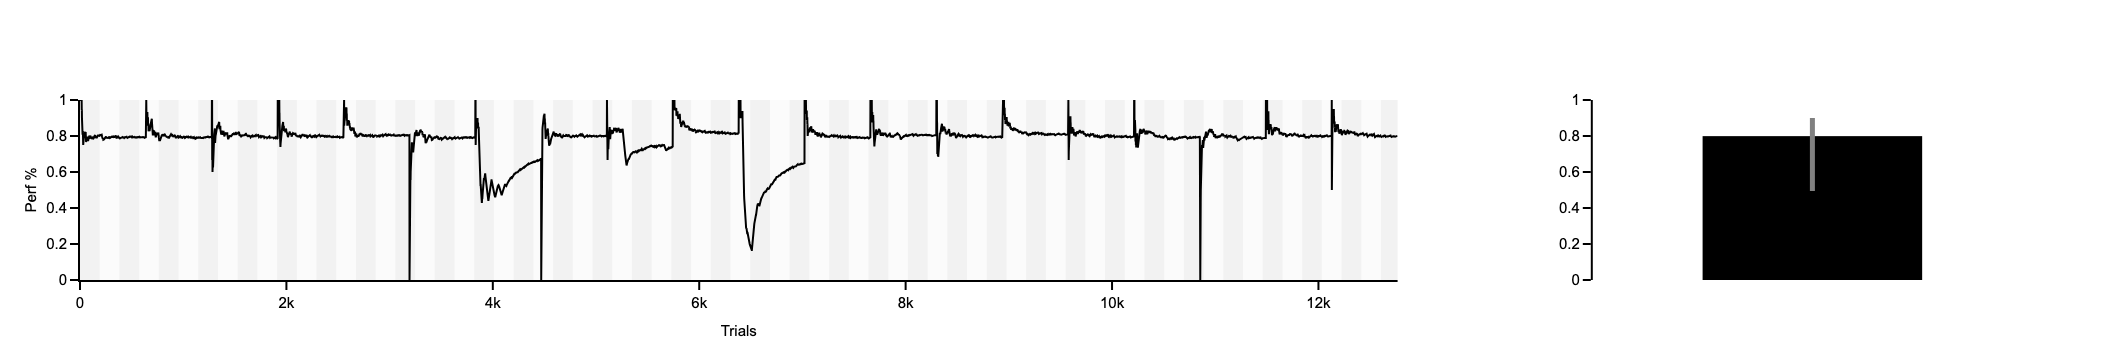

In [99]:
fig = make_subplots(rows=1, cols=2, column_widths=[0.75, 0.25], print_grid=False)


fig.add_trace(go.Scatter(y=perf_runs[~np.isnan(perf_runs)], 
                         line=dict(color='black')), 
              row=1, col=1)


perf_median = np.median(perf_runs[~np.isnan(perf_runs)])
ci_low = np.quantile(perf_runs[~np.isnan(perf_runs)], 0.025)
ci_up = np.quantile(perf_runs[~np.isnan(perf_runs)], 0.975)





fig.add_trace(go.Bar(#x=['attentional task performance'], 
                     y=[perf_median], 
                     marker=dict(color='black'),
                     error_y=dict(type='data', 
                                  symmetric=False, 
                                  array=[ci_up - perf_median], 
                                  arrayminus=[perf_median - ci_low], 
                                  thickness=5, 
                                  width=0,
                                  color='gray'), 
                     width=0.5),
              
              row=1, col=2)


step = 191
x_max = len(perf_runs[~np.isnan(perf_runs)])  

for i in range(0, x_max, step):
    fig.add_shape(type="rect", 
                  x0=i, 
                  x1=i + step, 
                  y0=0, 
                  y1=1, 
                  fillcolor="gray" if (i // step) % 2 == 0 else "lightgray", 
                  opacity=0.1,
                  layer="below", 
                  line_width=0)

fig.update_xaxes(showline=True, range=[0,x_max], title='Trials', row=1, col=1)
fig.update_yaxes(showline=True, range=[0,1], title='Perf %',row=1, col=1)

fig.update_xaxes(showline=False, visible=False, row=1, col=2)
fig.update_yaxes(showline=True,range=[0,1],row=1, col=2)
fig.update_layout(template=fig_template, showlegend=False, width=fig_width)
fig.show()